### Analyze gas station data

In [65]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [37]:
# Function to clean price strings to floats
def clean_price(price_str):
    if isinstance(price_str, str) and '/' in price_str:
        return float(price_str.split('/')[0].strip())
    return None

In [69]:
# Load the gas station data from the JSON file and create a pandas DataFrame
with open('all_stations.json', 'r', encoding='utf-8') as file:
    stations_data = json.load(file)

# Create DataFrame from the stations data
df = pd.DataFrame(stations_data)

df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

# Define fuel type mapping from Hungarian to English
fuel_type_mapping = {
    '95-ös Benzin E10': 'gasoline_95_e10',
    'Gázolaj': 'diesel',
    'Lpg': 'lpg',
    '100-As Benzin E5': 'gasoline_100_e5',
    'Cng': 'cng',
    'Prémium Gázolaj': 'diesel_premium',
    'Prémium Benzin E10': 'gasoline_premium_e10',
    '100-As Benzin E10': 'gasoline_100_e10',
    'Adblue Töltőpisztolyos': 'adblue'
}

# Extract and clean fuel prices
for station in df.index:
    if 'fuels' in df.loc[station] and df.loc[station, 'fuels']:
        for fuel_type, fuel_data in df.loc[station, 'fuels'].items():
            if 'price' in fuel_data:
                # Map Hungarian fuel type to English
                english_name = fuel_type_mapping.get(fuel_type, fuel_type.replace('-', '').replace(' ', '_').lower())
                col_name = f"price_{english_name}"
                df.loc[station, col_name] = clean_price(fuel_data['price'])

# Clean the original price column (which is diesel)
# No need for a separate diesel column as it's already included
# from the fuels dictionary

# Drop unnecessary columns
df.drop(columns=['price', 'fuels', 'default_fuel_type'], errors='ignore', inplace=True)

In [70]:
df.head(3)

,brand,distance,address,lat,lon,date,url,price_diesel,price_gasoline_100_e5,price_diesel_premium,price_gasoline_95_e10,price_gasoline_premium_e10,price_lpg,price_gasoline_100_e10,price_cng,price_adblue
0,Mol,0.86 km,"Budapest III, Árpád fejedelem út 103.",47.536095,19.046404,2025-04-15,https://holtankoljak.hu/mol_budapest_iii_4#tar...,595.0,638.0,659.0,585.0,NaN,NaN,NaN,NaN,NaN
1,Mol,1.73 km,"Budapest III, Szentendrei út 100.",47.550388,19.043095,2025-04-15,https://holtankoljak.hu/mol_budapest_iii_1086#...,595.0,637.0,659.0,584.0,NaN,NaN,NaN,NaN,NaN
2,Shell,1.84 km,"Budapest XIII, Népfürdő u. 14.",47.529625,19.057652,2025-04-12,https://holtankoljak.hu/shell_budapest_xiii_53...,593.9,657.9,648.9,582.9,NaN,NaN,NaN,NaN,NaN


In [71]:
# Get basic statistics for numeric columns
print("\nBasic statistics for numeric columns:")
numeric_stats = df.select_dtypes(include=['number']).describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.90, 0.99])

numeric_stats.T.round(3).sort_values(by='mean', ascending=False)


Basic statistics for numeric columns:


,count,mean,std,min,1%,5%,25%,50%,75%,90%,99%,max
price_diesel_premium,930.0,652.675,19.112,589.000,595.000,619.405,648.900,651.900,659.000,660.000,713.000,730.900
price_gasoline_100_e5,880.0,640.058,18.808,580.000,595.000,609.900,634.000,637.000,657.900,657.900,687.000,718.900
price_gasoline_100_e10,125.0,620.894,11.914,610.000,610.720,617.000,617.000,617.000,618.000,625.940,664.760,665.000
price_gasoline_premium_e10,294.0,616.943,13.281,576.000,582.830,609.900,609.900,611.400,619.900,622.900,654.900,680.900
price_diesel,1212.0,594.367,14.701,550.900,561.000,572.000,593.000,594.900,595.000,597.000,645.000,659.900
price_gasoline_95_e10,1193.0,584.598,13.390,550.000,560.000,569.900,582.000,582.900,584.000,586.000,634.000,643.900
price_adblue,150.0,393.549,103.719,245.000,249.490,259.900,290.500,390.000,499.000,500.000,590.000,699.900
price_lpg,329.0,378.257,15.826,329.000,339.000,360.360,373.000,373.000,387.000,403.000,416.000,449.000
lat,1286.0,47.242,0.565,44.500,46.025,46.218,46.854,47.394,47.614,47.922,48.266,48.538
lon,1286.0,19.248,1.735,16.276,16.577,16.988,18.320,19.090,20.121,21.195,22.214,47.451


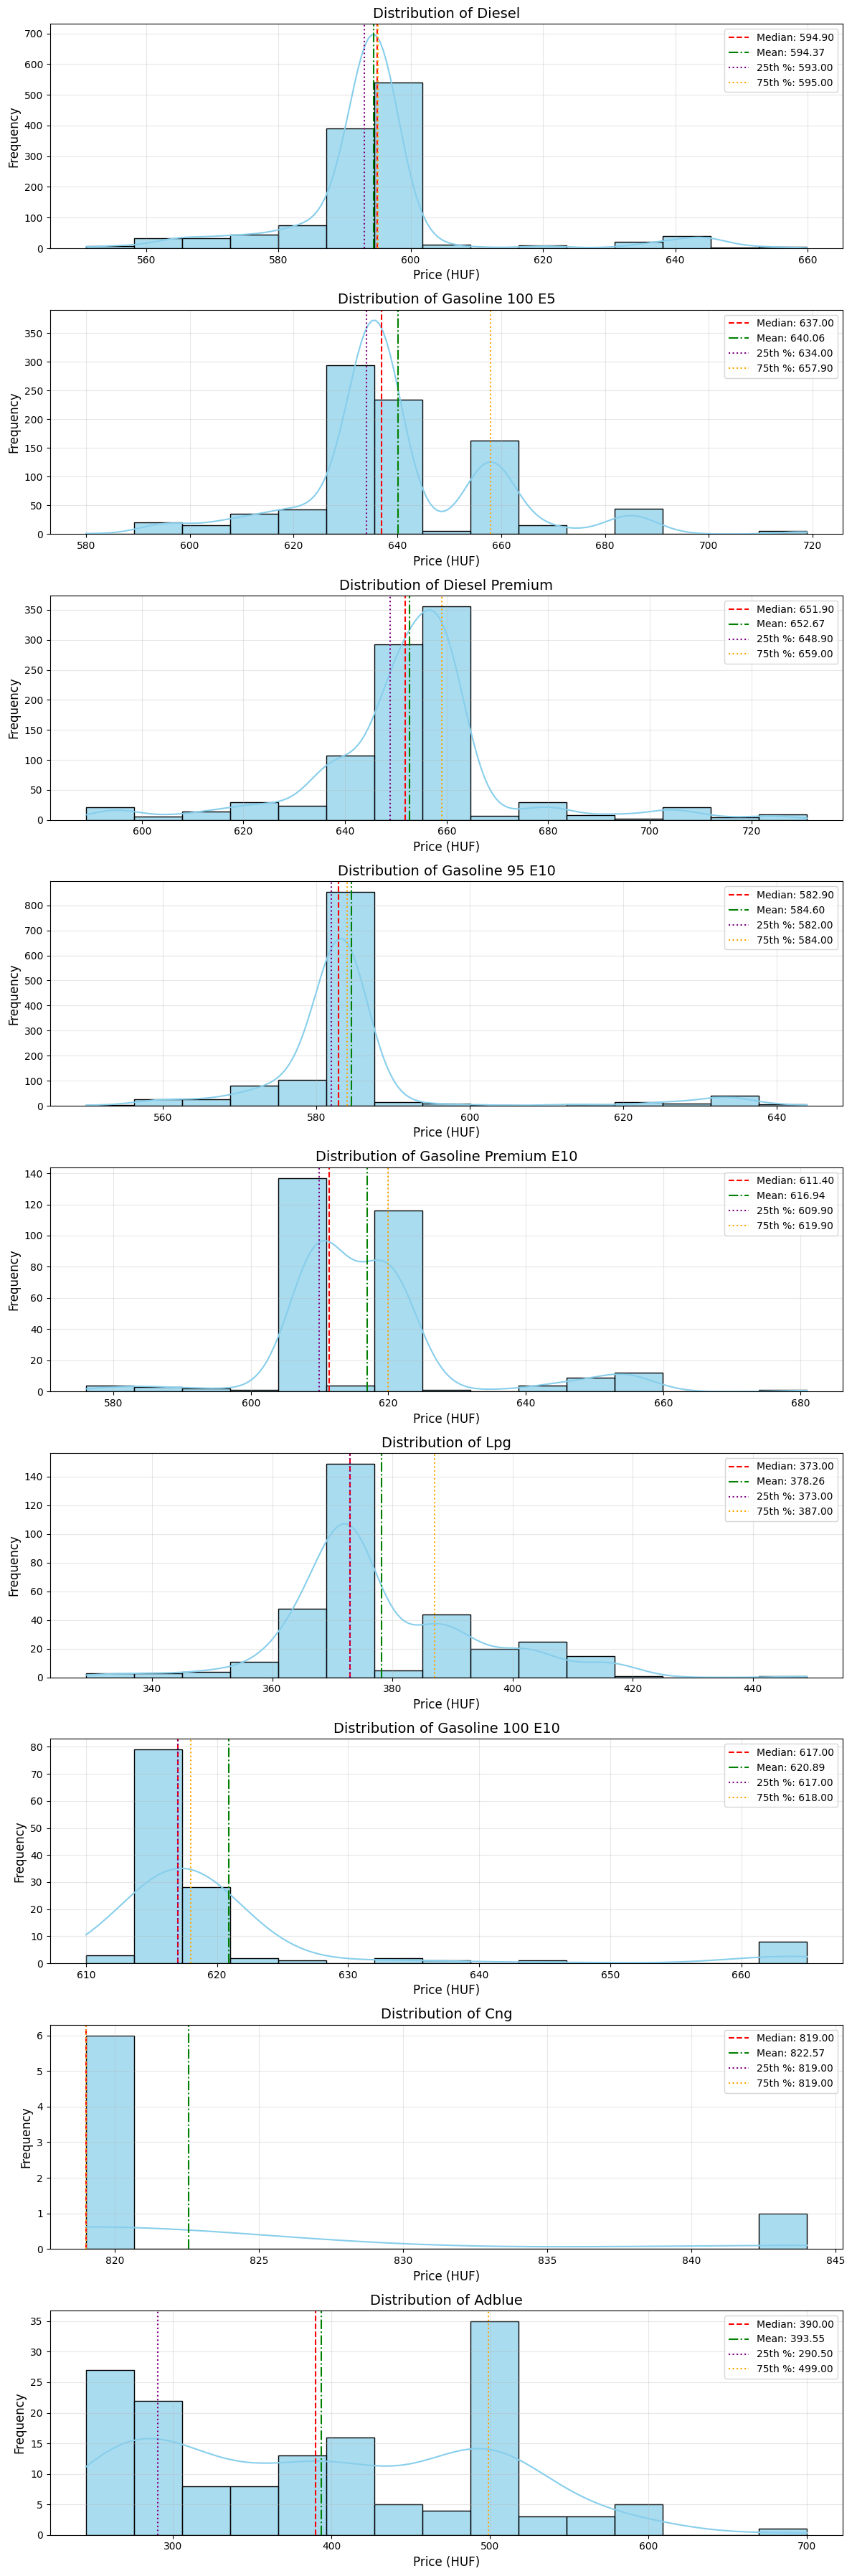

In [72]:
# Plot distributions for price columns
price_columns = [col for col in df.columns if col.startswith('price_') and df[col].notna().any()]

if price_columns:
    # Set up the figure with appropriate size
    fig, axes = plt.subplots(len(price_columns), 1, figsize=(12, 4*len(price_columns)))
    
    # If there's only one price column, axes won't be an array
    if len(price_columns) == 1:
        axes = [axes]
    
    # Plot each price column
    for i, col in enumerate(price_columns):
        # Clean column name for display
        display_name = col.replace('price_', '').replace('_', ' ').title()
        
        # Get data without NaN values
        data = df[col].dropna()
        
        if len(data) > 0:
            # Create histogram with KDE and wider bars (reduced number of bins)
            sns.histplot(data, kde=True, ax=axes[i], color='skyblue', edgecolor='black', alpha=0.7, bins=15)
            
            # Add vertical lines for key statistics
            median = data.median()
            mean = data.mean()
            axes[i].axvline(median, color='red', linestyle='--', label=f'Median: {median:.2f}')
            axes[i].axvline(mean, color='green', linestyle='-.', label=f'Mean: {mean:.2f}')
            
            # Add percentile lines
            percentile_25 = data.quantile(0.25)
            percentile_75 = data.quantile(0.75)
            axes[i].axvline(percentile_25, color='purple', linestyle=':', label=f'25th %: {percentile_25:.2f}')
            axes[i].axvline(percentile_75, color='orange', linestyle=':', label=f'75th %: {percentile_75:.2f}')
            
            # Set title and labels
            axes[i].set_title(f'Distribution of {display_name}', fontsize=14)
            axes[i].set_xlabel('Price (HUF)', fontsize=12)
            axes[i].set_ylabel('Frequency', fontsize=12)
            axes[i].legend()
            
            # Add grid for better readability
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, f'No data available for {display_name}', 
                         horizontalalignment='center', verticalalignment='center',
                         transform=axes[i].transAxes, fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("No price columns found with data.")


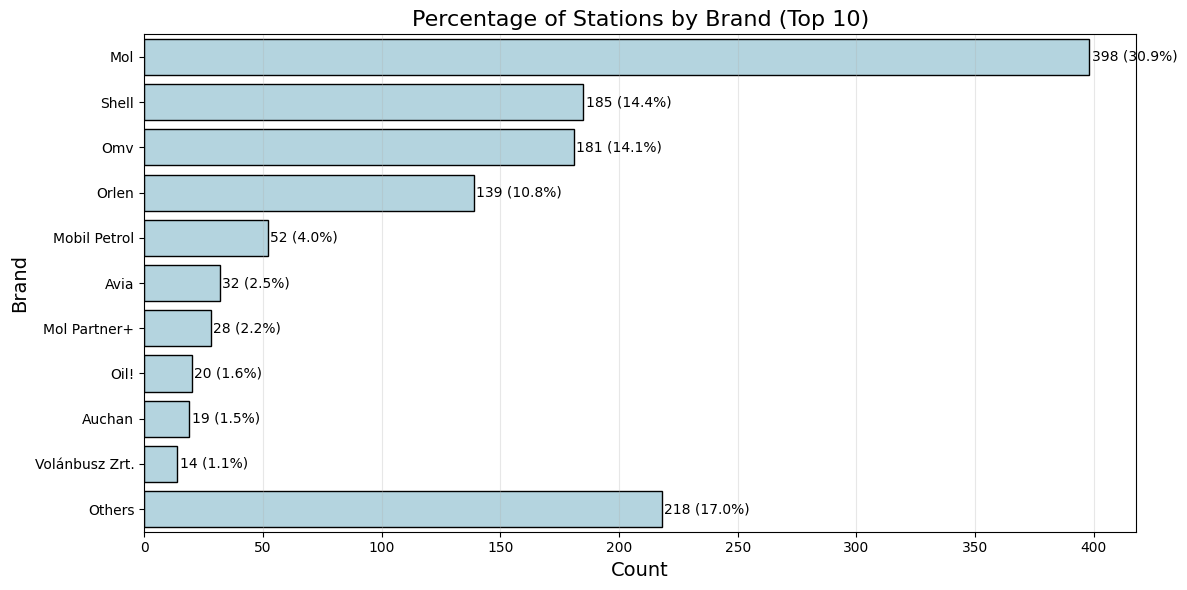

In [73]:
# Create a count plot for brands - showing top 10 and grouping others
plt.figure(figsize=(12, 6))
brand_counts = df['brand'].value_counts()
total_stations = len(df)
# Get top 10 brands
top_10_brands = brand_counts.nlargest(10)
# Sum up the rest as "Others"
others_count = brand_counts[10:].sum()
# Create a new series with top 10 and Others
plot_data = pd.concat([top_10_brands, pd.Series({'Others': others_count})])
# Calculate percentages
percentages = (plot_data / total_stations * 100).round(1)
# Convert to DataFrame for easier plotting
plot_df = pd.DataFrame({
    'Brand': plot_data.index, 
    'Count': plot_data.values,
    'Percentage': percentages.values
})
# Plot the data - transposed (horizontal bars) with light blue color and black edges
ax = sns.barplot(x='Count', y='Brand', data=plot_df, color='lightblue', edgecolor='black')
plt.title('Percentage of Stations by Brand (Top 10)', fontsize=16)
plt.ylabel('Brand', fontsize=14)
plt.xlabel('Count', fontsize=14)
# Add percentage labels to the bars
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height()/2, 
            f'{width:.0f} ({plot_df.Percentage.iloc[i]:.1f}%)', 
            va='center')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

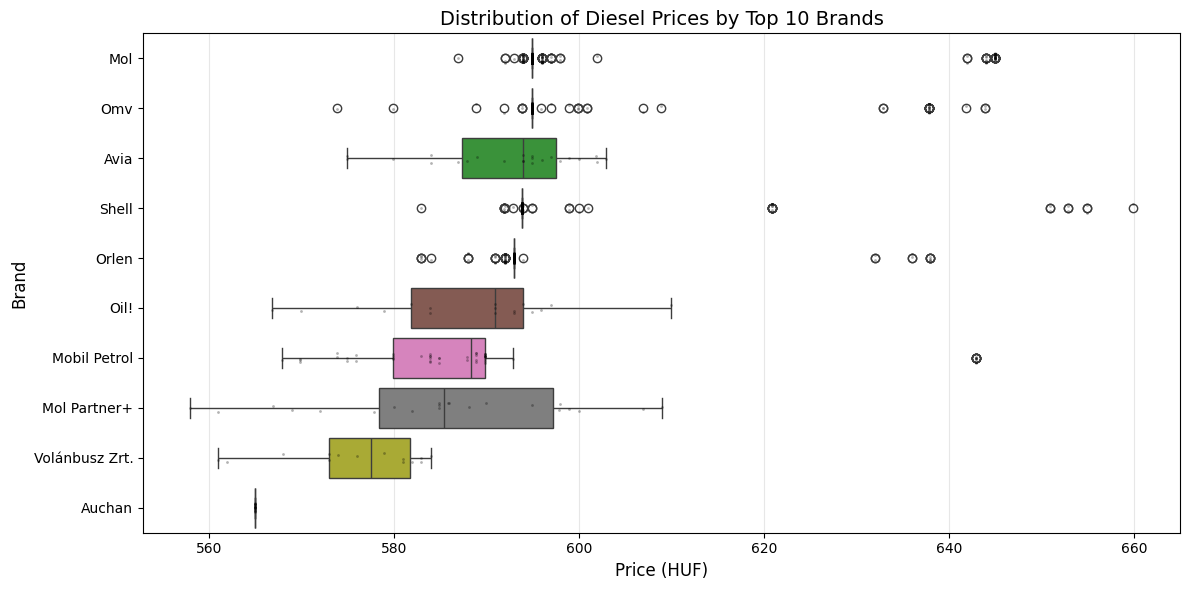

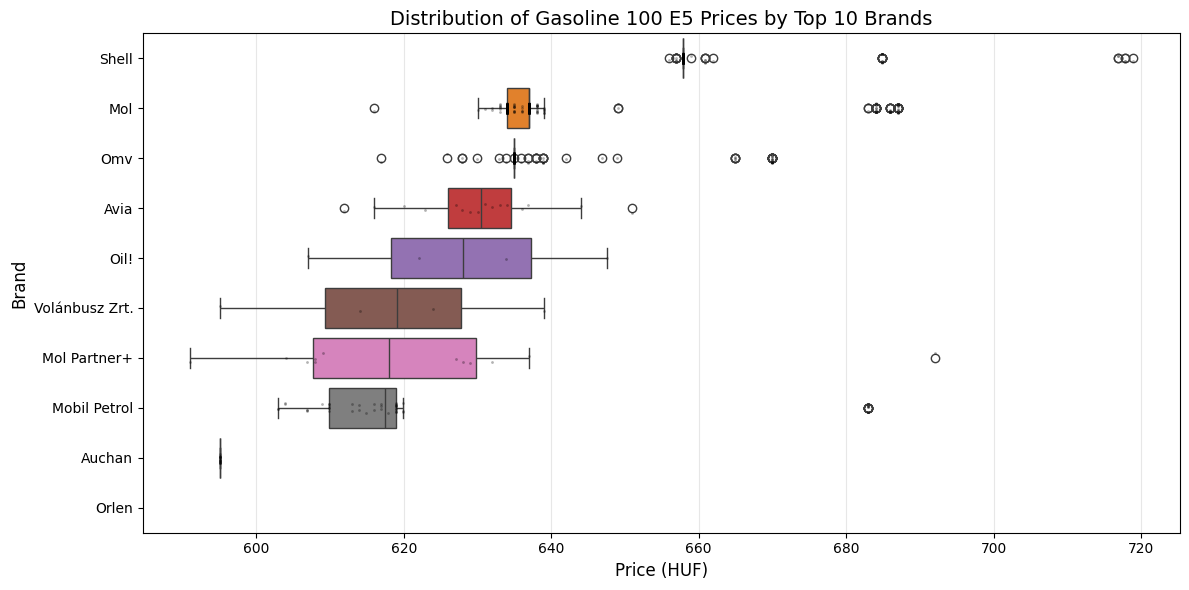

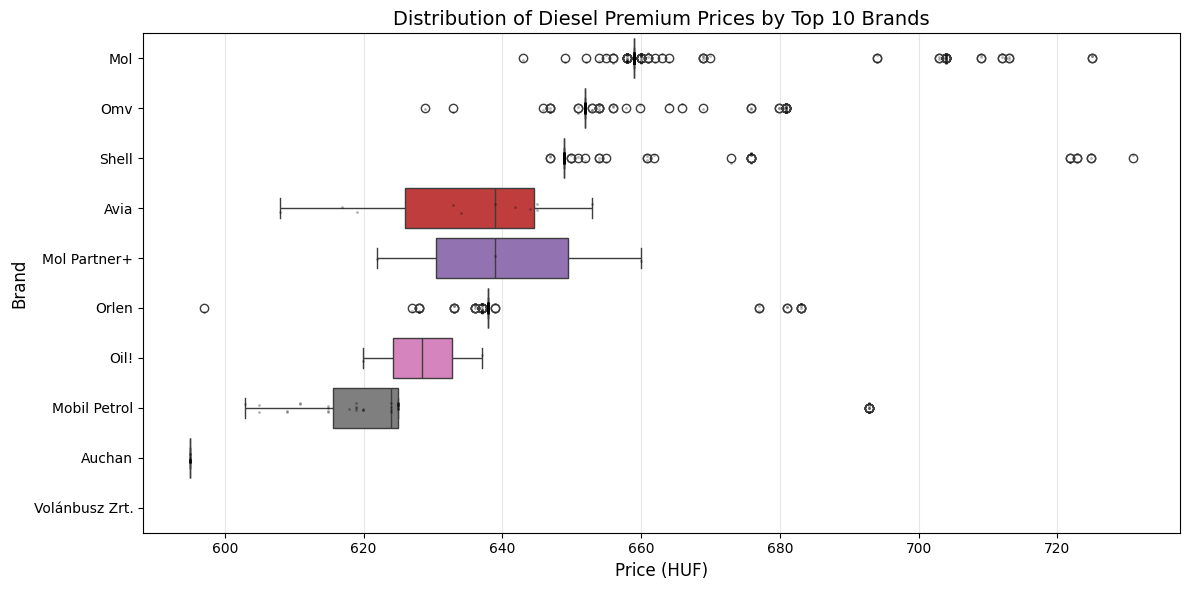

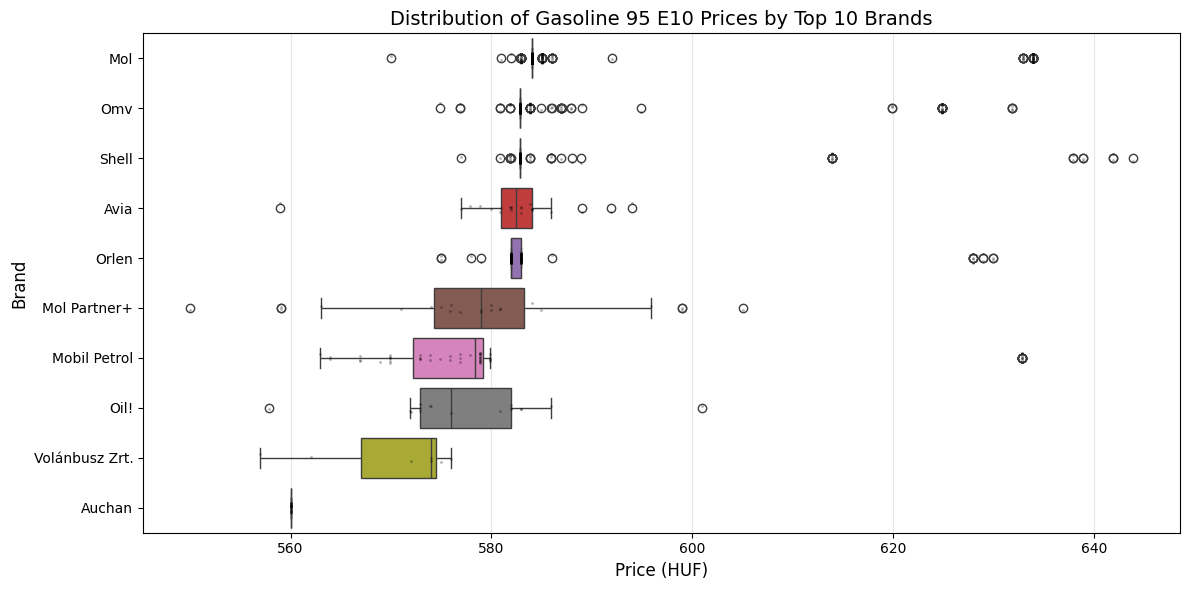

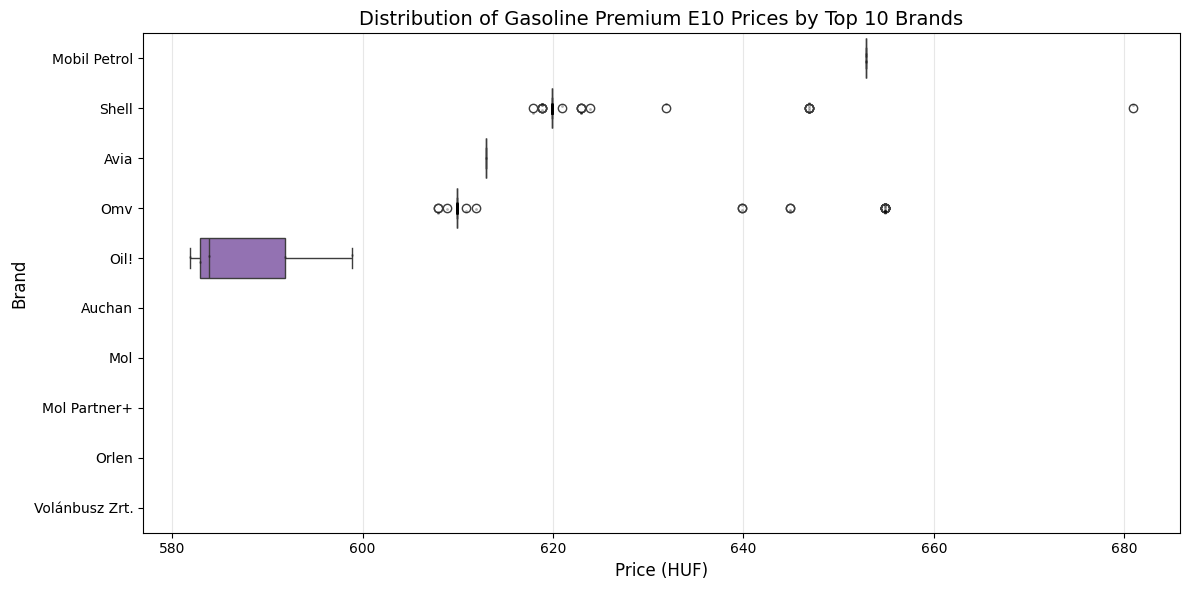

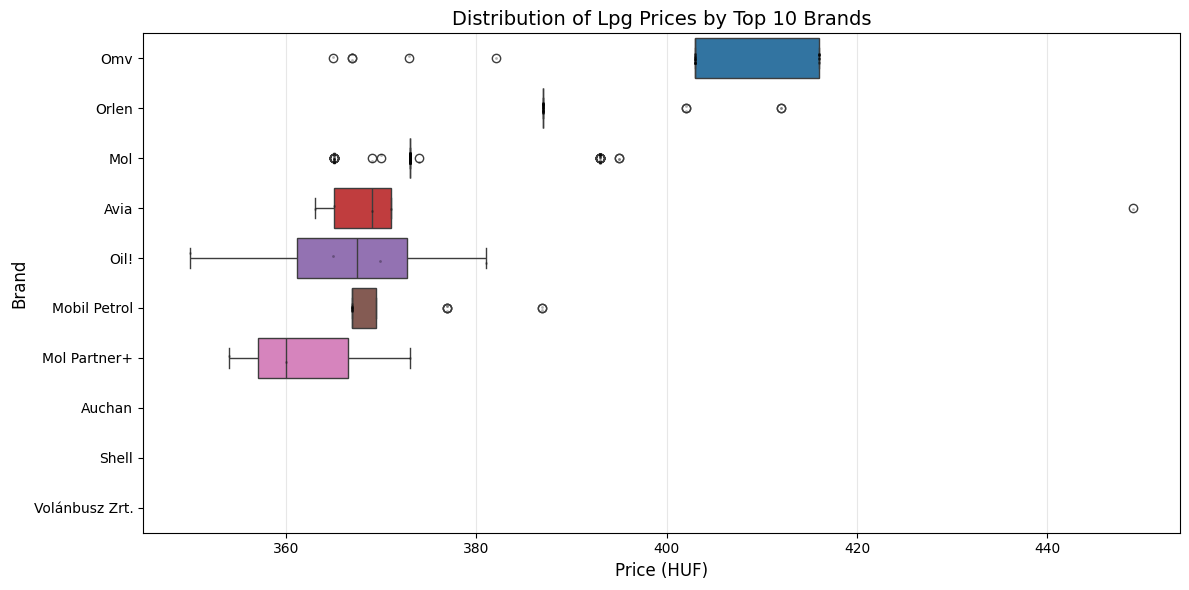

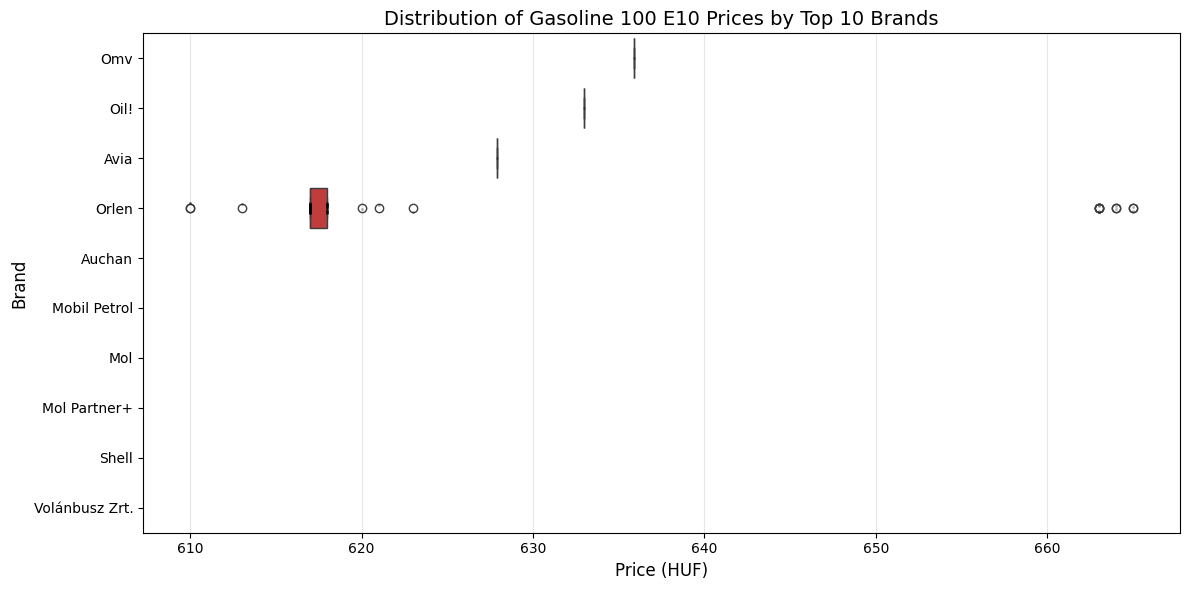

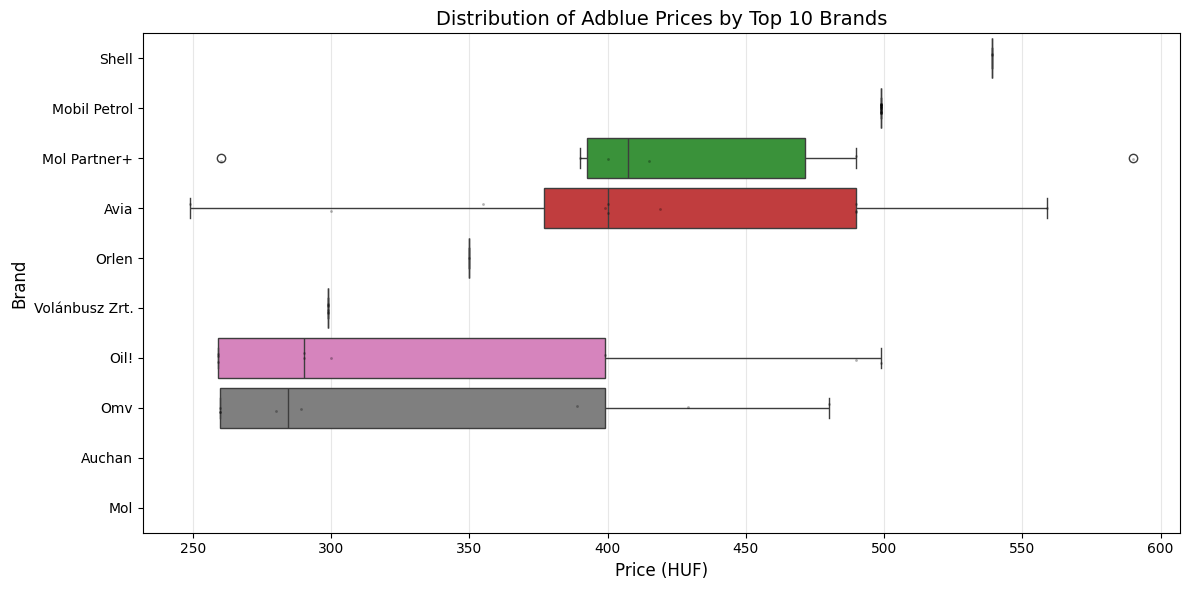

In [74]:
# Create boxplots for price distribution by top 10 brands
price_columns = [col for col in df.columns if col.startswith('price_') and df[col].notna().any()]

# Get top 10 brands from the previous cell
top_10_brands = brand_counts.nlargest(10).index.tolist()

for price_col in price_columns:
    # Skip if there's not enough data
    if df[price_col].count() < 10:
        continue
        
    # Clean column name for display
    display_name = price_col.replace('price_', '').replace('_', ' ').title()
    
    # Filter data for top 10 brands only
    filtered_df = df[df['brand'].isin(top_10_brands)].copy()
    
    # Calculate median for each brand to sort by
    brand_medians = filtered_df.groupby('brand')[price_col].median().sort_values(ascending=False)
    
    # Create figure - more compact size
    plt.figure(figsize=(12, 6))
    
    # Order brands by median price (descending)
    filtered_df['brand'] = pd.Categorical(
        filtered_df['brand'], 
        categories=brand_medians.index,
        ordered=True
    )
    
    # Create horizontal boxplot with brands on y-axis and prices on x-axis
    # Fix the FutureWarning by using hue parameter instead of palette directly
    ax = sns.boxplot(x=price_col, y='brand', hue='brand', data=filtered_df, legend=False)
    
    # Add stripplot for individual data points
    # Note: The markers appear as different sizes because:
    # - When points overlap, they appear as larger circles
    # - Individual points appear as smaller dots
    # Using jitter=True to spread points horizontally and avoid excessive overlap
    sns.stripplot(y='brand', x=price_col, data=filtered_df, color='black', 
                 alpha=0.3, size=2, jitter=True)
    
    # Set title and labels
    plt.title(f'Distribution of {display_name} Prices by Top 10 Brands', fontsize=14)
    plt.ylabel('Brand', fontsize=12)
    plt.xlabel(f'Price (HUF)', fontsize=12)
    
    # Add grid for better readability
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [96]:
# Create a new column for brand_cleaned (top 10 brands + 'Other')
top_10_brands = df['brand'].value_counts().nlargest(10).index
df['brand_cleaned'] = df['brand'].apply(lambda x: x if x in top_10_brands else 'Other')

# Create the map
fig = px.scatter_map(
    df, 
    lat='lat', 
    lon='lon',
    color='brand_cleaned',
    hover_name='brand',
    hover_data=['address', 'price_diesel', 'price_gasoline_95_e10', 'date'],
    zoom=7,
    height=700,
    width=1200,
    title='Fuel Stations Map by Brand',
    map_style='carto-voyager-nolabels'
)

#'basic'`, `'carto-darkmatter'`, `'carto-darkmatter-nolabels'`, `'carto-positron'`, `'carto-positron-nolabels'`, `'carto-voyager'`, #`'carto-voyager-nolabels'`, `'dark'`, `'light'`, `'open-street-map'`, `'outdoors'`, `'satellite'`, `'satellite-streets'`, #`'streets'`, `'white-bg'

# Update the map layout
fig.update_layout(
    #mapbox_style="open-street-map",  # Try different styles from the list above
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()